<a href="https://colab.research.google.com/github/nyluje/RCP209DeeplabExperiment/blob/main/RCP209_Project_2022_Deeplab_Experiment_With_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import des librairies utilisées dans le projet

Au moment de la réalisation du projet l'environnement par défaut du service Google Colab utilisait les versions suivantes des librairies:

* `numpy version 1.21.5`
* `matplotlib version 3.2.2`
* `torch version 1.10.0+cu111`
* `torchvision version 0.11.1+cu111`
* `python version 3.7.13 (default, Mar 16 2022, 17:37:17) [GCC 7.5.0]`



In [1]:
#import des librairie utilisée

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import gridspec


import torch
from torch.nn import parameter
from torch import cuda
from torch.utils.data import DataLoader, Subset
import torch.optim as optim


import torchvision
from torchvision.datasets import VOCSegmentation
from torchvision import transforms as T, models
from torchvision.io import read_image

import os
import time
import datetime
import random
import sys
import copy
from pathlib import Path



print(f'numpy version {np.__version__}')
print(f'matplotlib version {matplotlib.__version__}')
print(f'torch version {torch.__version__}')
print(f'torchvision version {torchvision.__version__}')
print(f'python version {sys.version}')

numpy version 1.21.6
matplotlib version 3.2.2
torch version 1.10.0+cu111
torchvision version 0.11.1+cu111
python version 3.7.13 (default, Mar 16 2022, 17:37:17) 
[GCC 7.5.0]


# Importation du modèle Deeplab v3 de la librairie Torchvision

Pour l'exemple, le modèle `deeplabv3_mobilenet_v3_large` est utilisé. Il est expliqué ci-dessous:
* Des détails sur l'articulation entre les 3 couches principales et les sous couches qui les constituent;
* Quelques remarques sur le code de la librairie.



## Explications sur les différentes couches utilisées

Le modèle est construit en trois parties:
* Le `backbone` correspond au modèle de classification de base, avec des poids pré-entrainés; Il est connecté au `classifier`, et aux différents `aux_classifier`;
* Le `classifier` donne le résultat en sortie de la classification par pixel;
* Le `aux_classifier` est un classifieur auxiliaire, comme dans le modèle GoogleLeNet. Il peut être utilisé dans l'entrainement des poids pour prendre en compte des couches intermédiaires du modèle.

### Couche `backbone` (Tansfer learning)

En entrée, le backbone est prévu pour recevoir un tenseur de taille 3 (les 3 couleurs RGB de l'image), composé pour chaque canal de couleur de la surface intégrale, en hauteur et largeur, de l'image d'origine. Une convolution de taille 3x3 est appliquée.
```
  (0): ConvNormActivation(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
    (2): Hardswish()
  )
```

En sortie du backbone, la 17ème couche fournit un tenseur de taille 960.
```
  (16): ConvNormActivation(
    (0): Conv2d(160, 960, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (1): BatchNorm2d(960, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
    (2): Hardswish()
  )
```

### Couche `classifier` (classifieur final)

La première couche à l'intérieur de `classifier` est constitué des éléments de pooling de pyramide spatiale à trous. Elle reçoit un tenseur de taille 960. En entrée (couche (0)), sur le modèle de l'inception, 5 opérations sont opérées sur le même tenseur de taille 960:
* Une convolution 1x1;
* Une convolution à trous de taille 3x3 avec une dilatation (un espace entre les éléments de la feature map utilisée) de taille 12;
* Une convolution à trous de taille 3x3 avec une dilatation de taille 24;
* Une convolution à trous de taille 3x3 avec une dilatation de taille 36;
* Et une couche de pooling;

Les 5 tenseurs partagent la même taille de sortie: 256. Chacun de ces tenseurs de sortie permet de capter des caractéristiques de la feature map d'entrée à différentes échelles.

```
  (0): ASPP(
    (convs): ModuleList(
      (0): Sequential(
        (0): Conv2d(960, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (1): ASPPConv(
        (0): Conv2d(960, 256, kernel_size=(3, 3), stride=(1, 1), padding=(12, 12), dilation=(12, 12), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (2): ASPPConv(
        (0): Conv2d(960, 256, kernel_size=(3, 3), stride=(1, 1), padding=(24, 24), dilation=(24, 24), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (3): ASPPConv(
        (0): Conv2d(960, 256, kernel_size=(3, 3), stride=(1, 1), padding=(36, 36), dilation=(36, 36), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (4): ASPPPooling(
        (0): AdaptiveAvgPool2d(output_size=1)
        (1): Conv2d(960, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): ReLU()
      )
    )
```

Les 5 tenseurs de taille 256 sont concaténés en un tenseur de taille 1280 qui sert d'input à la couche suivante. Les poids associés à cette couche vont permettre de pondérer l'interprétation des différentes échelles.
```
    (project): Sequential(
      (0): Conv2d(1280, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Dropout(p=0.5, inplace=False)
    )
```

En sortie, un tenseur de taille 21 est rendu, correspondant aux 21 classes. Si le modèle devait être modifié pour classer un nombre différent de classes que les 21 classes du jeu de données Pascal VOC, il faudrait modifier la taille de cette sortie.
```
  (4): Conv2d(256, 21, kernel_size=(1, 1), stride=(1, 1))
```

### Couche `aux_classifier` (classifieur auxiliaire)

Concernant le classifieur auxiliaire, il est à noter qu'il prend en entrée un tenseur de taille 40, ce qui permet de déduire qu'il doit être connecté à des couches du backbone donnant en sortie cette taille là (c'est le cas pour la 6ème couche et 7ème couche du backbone, indexées 5 et 6).
```
  (0): Conv2d(40, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
```

En sortie, le classifieur auxiliaire donne un tenseur de taille 21 (nombre de classes de Pascal VOC), comme pour le classifieur final, il faudrait modifier cette taille de sortie s'il était souhaité modifier les classes d'objets du classifieur.
```
  (4): Conv2d(10, 21, kernel_size=(1, 1), stride=(1, 1))
```

## Remarques sur la classe Deeplab v3 de la [classe torchvision](https://pytorch.org/vision/main/_modules/torchvision/models/segmentation/deeplabv3.html#deeplabv3_mobilenet_v3_large)

En observant le code du package: [TORCHVISION.MODELS.SEGMENTATION.DEEPLABV3](https://pytorch.org/vision/main/_modules/torchvision/models/segmentation/deeplabv3.html), il est possible de remarquer que la classe `DeepLabV3` hérite de la classe `_SimpleSegmentationModel`: `DeepLabV3(_SimpleSegmentationModel)`.

En observant le contenu du code de cette classe [`_SimpleSegmentationModel`](https://github.com/pytorch/vision/blob/main/torchvision/models/segmentation/_utils.py):

- En entrée, elle prend 3 arguments de type `Module` pour déterminer quels types de classes sont à utiliser pour `backbone`, `classifier` et `aux_classifier`; Respectivement:
 - Classe [`mobilenet_v3_large()`](https://github.com/pytorch/vision/blob/main/torchvision/models/mobilenetv3.py) pour le `backbone`;
 - Classe `DeepLabHead()` pour le `classifier` (décrit dans [TORCHVISION.MODELS.SEGMENTATION.DEEPLABV3](https://pytorch.org/vision/main/_modules/torchvision/models/segmentation/deeplabv3.html));
 - Classe `FCNHead()` pour `aux_classifier` (décrit dans [TORCHVISION.MODELS.SEGMENTATION.DEEPLABV3](https://pytorch.org/vision/main/_modules/torchvision/models/segmentation/deeplabv3.html));

- Dans la fonction forward, `forward()`, il faut remarquer, qu'il est utilisé la fonction [`torch.nn.functional.interpolate()`](https://pytorch.org/docs/stable/generated/torch.nn.functional.interpolate.html) (ligne: `x = F.interpolate(x, size=input_shape, mode="bilinear", align_corners=False)`) pour re-projeter à la taille d'origine de l'image le résultat de la segmentation. Cette action rend possible la superposition du masque de segmentation sur l'image d'origine à une même échelle.





In [2]:

#importation d'un model deeplab prédéfini
model_dl=models.segmentation.deeplabv3_mobilenet_v3_large(pretrained=True,progress=False)

#https://github.com/pytorch/vision/blob/main/torchvision/models/segmentation/deeplabv3.py definition 
"""
        backbone (nn.Module): the network used to compute the features for the model.
            The backbone should return an OrderedDict[Tensor], with the key being
            "out" for the last feature map used, and "aux" if an auxiliary classifier
            is used.
        classifier (nn.Module): module that takes the "out" element returned from
            the backbone and returns a dense prediction.
        aux_classifier (nn.Module, optional): auxiliary classifier used during training
"""

#backbone correspondond au modèle de base, 
print("\r\n")
print("***** backbone layers *****")
print(f"base model backbone, on top of wich DeepLab is built is composed of {model_dl.backbone.__len__()} layers")
print("\r\n")
print(model_dl.backbone)

#classifier concerne la partie deeplab: DeepLabHead dans laquelle on retrouve la convolution à trou
print("\r\n")
print("***** classifier layers *****")
print(f"classifier is composed of {model_dl.classifier.__len__()} layers")
print("\r\n")
print(model_dl.classifier)


#et également aux classifier
print("\r\n")
print("***** auxiliary Classifier layers *****")
print(f"auxiliary classifier is composed of {model_dl.aux_classifier.__len__()} layers")
print("\r\n")
print(model_dl.aux_classifier)



Downloading: "https://download.pytorch.org/models/deeplabv3_mobilenet_v3_large-fc3c493d.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_mobilenet_v3_large-fc3c493d.pth




***** backbone layers *****
base model backbone, on top of wich DeepLab is built is composed of 17 layers


IntermediateLayerGetter(
  (0): ConvNormActivation(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
    (2): Hardswish()
  )
  (1): InvertedResidual(
    (block): Sequential(
      (0): ConvNormActivation(
        (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
        (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
      (1): ConvNormActivation(
        (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      )
    )
  )
  (2): InvertedResidual(
    (block): Sequential(
      (0): ConvNormActivation(
        (0): Conv2d(1

# Fonctions pour bloquer le calcul de gradient

L'objectif des quelques fonctions ci-dessous est de permettre de bloquer les calculs du gradient pour certaines couches et les laisser libre pour d'autres. Sur les couches laissées libres, il est possible de mettre les poids à 0.01 pour un entraînement s'affranchissant des poids par défaut du modèle d'origine.

Dans la démonstration, il n'est utilisé que la situation où l'apprentissage du gradient est bloqué sur toutes les couches à l'exception de la dernière couche (celle classifiant entre les 21 classes), avec pour règle sur les poids:
* Soit une initialisation des poids à 0.01;
* Soit les poids par défaut du modèle.


In [3]:



#fonction pour bloquer ou libérer le calcul de gradient d'un model ou d'une partie d'un model
def set_parameters_requires_grad(model,req_grad,set_to_zero_weight):
    for param in model.parameters():
      param.requires_grad = req_grad
    for name, param in model.named_parameters():
      if set_to_zero_weight is True:
        param.data.fill_(0.01)


#fonction pour compter les paramètres bloqués ou non d'un model ou d'une partie d'un model
def display_count_grad_val_true_and_false_parameters(model):
  count_true=0
  count_false=0
  for param in model.parameters():
    if param.requires_grad is True:
      count_true+=1
    else:
      count_false+=1
  print(f'On model {model.__class__.__name__}, alterable gradient parameters number is {count_true},blocked gradient parameters number is: {count_false}')


#fonction pour bloquer les paramètres du modèle
def block_parameters_in_layers(model,backbone_layers_to_set_loose=0,aux_classifier_layers_to_set_loose=0,classifier_layers_to_set_loose=0,set_to_zero_weight=False,rewind_from_final_layer=True):
  block_parameters=True
  backbone_number_of_layers= model.backbone.__len__()
  aux_classifier_number_of_layers= model.aux_classifier.__len__() 
  classifier_number_of_layers= model.classifier.__len__() 
  #print(f"backbone_number_of_layers {backbone_number_of_layers}, aux_classifier_number_of_layers {aux_classifier_number_of_layers} , classifier_number_of_layers {classifier_number_of_layers}")

  if (backbone_layers_to_set_loose<=backbone_number_of_layers)&(aux_classifier_layers_to_set_loose<=aux_classifier_number_of_layers)&(classifier_layers_to_set_loose<=classifier_number_of_layers):
    set_parameters_requires_grad(model.backbone,False,False)
    set_parameters_requires_grad(model.aux_classifier,False,False)  
    set_parameters_requires_grad(model.classifier,False,False)  

    if rewind_from_final_layer is False:
      #Selection au hasard des couches sur lesquels les paramètres de gradient seront débloqués pour mise à jour possible
      layers_to_set_loose_on_backbone = np.random.choice(np.arange(backbone_number_of_layers), backbone_layers_to_set_loose, replace=False)
      layers_to_set_loose_on_classifier = np.random.choice(np.arange(classifier_number_of_layers), classifier_layers_to_set_loose, replace=False)
      layers_to_set_loose_on_aux_classifier = np.random.choice(np.arange(aux_classifier_number_of_layers), aux_classifier_layers_to_set_loose, replace=False)
    else:
      layers_to_set_loose_on_backbone = np.flip(np.arange(backbone_number_of_layers))[0:backbone_layers_to_set_loose]
      layers_to_set_loose_on_classifier = np.flip(np.arange(classifier_number_of_layers))[0:classifier_layers_to_set_loose]
      layers_to_set_loose_on_aux_classifier = np.flip(np.arange(aux_classifier_number_of_layers))[0:aux_classifier_layers_to_set_loose]
  
    for ltslob in layers_to_set_loose_on_backbone: set_parameters_requires_grad(model.backbone[str(ltslob)],True, set_to_zero_weight)
    for ltsloc in layers_to_set_loose_on_classifier: set_parameters_requires_grad(model.classifier[ltsloc],True,  set_to_zero_weight)
    for ltsloac in layers_to_set_loose_on_aux_classifier: set_parameters_requires_grad(model.aux_classifier[ltsloac],True,set_to_zero_weight)  

  else:
    raise Exception(f"Number of layers required to set loose is more than availabe in one of the 3 main layers, backbone_layers_to_set_loose: {backbone_layers_to_set_loose} , backbone_number_of_layers: {backbone_number_of_layers} ; aux_classifier_to_set_loose: {aux_classifier_to_set_loose} , aux_classifier_number_of_layers: {aux_classifier_number_of_layers} ; classifier_layers_to_set_loose: {classifier_layers_to_set_loose} , classifier_number_of_layers: {classifier_number_of_layers}")





In [4]:

display_count_grad_val_true_and_false_parameters(model_dl.backbone)
display_count_grad_val_true_and_false_parameters(model_dl.classifier)
display_count_grad_val_true_and_false_parameters(model_dl.aux_classifier)


print("-"*10)


block_parameters_in_layers(model_dl,backbone_layers_to_set_loose=1,aux_classifier_layers_to_set_loose=0,classifier_layers_to_set_loose=1,set_to_zero_weight=False)

display_count_grad_val_true_and_false_parameters(model_dl.backbone)
display_count_grad_val_true_and_false_parameters(model_dl.classifier)
display_count_grad_val_true_and_false_parameters(model_dl.aux_classifier)


On model IntermediateLayerGetter, alterable gradient parameters number is 170,blocked gradient parameters number is: 0
On model DeepLabHead, alterable gradient parameters number is 23,blocked gradient parameters number is: 0
On model FCNHead, alterable gradient parameters number is 5,blocked gradient parameters number is: 0
----------
On model IntermediateLayerGetter, alterable gradient parameters number is 3,blocked gradient parameters number is: 167
On model DeepLabHead, alterable gradient parameters number is 2,blocked gradient parameters number is: 21
On model FCNHead, alterable gradient parameters number is 0,blocked gradient parameters number is: 5


# Chargement du jeu de données Pascal VOC 2012

## Fonction pour identifier les maximums et minimums des hauteurs et largeurs d'un ensemble d'images

Cette fonction permet de déterminer les hauteurs et largeurs maximum et minimimum sur un jeu d'images. Cette information est ensuite utilisée pour déterminer le padding à appliquer afin de normaliser les images à la même taille, afin d'être en mesure de grouper celles-ci dans un même tenseur.

In [5]:
#cette fonction détermine les différences de taille hauteur et largeur de chaque 
def min_pad_to_apply_based_on_image_set(voctocheck, verbose=True):
  max_height=0
  max_width=0
  min_height=0
  min_width=0
  min_pad_on_width=0
  min_pad_on_height=0
  min_pad=0

  start_time = time.time()
  for i in range(0,voctocheck.__len__()):
    min_height = voctocheck[i][0].height if voctocheck[i][0].height<min_height or min_height==0 else min_height
    min_width = voctocheck[i][0].width if voctocheck[i][0].width<min_width or min_width==0 else min_width
    max_height = voctocheck[i][0].height if voctocheck[i][0].height>max_height else max_height
    max_width = voctocheck[i][0].width if voctocheck[i][0].width>max_width else max_width
    min_pad_on_height=max_height-min_height
    min_pad_on_width=max_width-min_width
    min_pad = min_pad_on_width if min_pad_on_width>min_pad_on_height else min_pad_on_height
  total_time= time.time()-start_time
  total_time_str=str(datetime.timedelta(seconds=int(total_time)))
  if verbose: 
    print(f'Time to iterate thru  was: {total_time_str}')
    print(f'max_height: {max_height}, max_width: {max_width}, min_height: {min_height}, min_width: {min_width}, min_pad_on_height: {min_pad_on_height}, min_pad_on_width: {min_pad_on_width},  min_pad: {min_pad}')
  return int(min_pad/2)

## Définition des `DataSet` et du `DataLoader`

Le jeu de données [VOCSegmentation](https://pytorch.org/vision/main/generated/torchvision.datasets.VOCSegmentation.html?highlight=vocsegmentation#torchvision.datasets.VOCSegmentation) est chargé sur l'environnement.


Les opérations de transformations suivantes sont appliquées sur les images du jeu de donnée et leur _ground truth_:
* Les images sont paddés de la valeur 255 qui correspond à une valeur à ignorée.  Ce détail est expliqué dans la documentation en ligne de [Pascal VOC 2012 (section 2.6)](http://host.robots.ox.ac.uk/pascal/VOC/voc2012/htmldoc/index.html) : 
> Les régions frontalières sont marquées de l'étiquette _void_ (index 255), indiquant que le le pixel peut être de n'importe quelle classe, incluant la classe d'arrière-plan;
* Les images sont ensuite rognées, selon leur centre, pour ne pas dépasser une taille de 500 par 500 pixels;
* Les images sont transformées en tenseur;
* Pour les images du jeu de données, il est appliqué également une normalisation.

Pour accélérer le temps de rendu de la démonstration (ne pas itérer à travers l'ensemble des 5717 images d'entrainement et 5823 de validation de Pascal VOC), des sous-ensembles sont choisis: 
* 200 parmi les images d'entrainement;
* Et 50 parmi les images de validation.

Un objet `DataLoader` est ensuite créé pour être utilisé dans l'entrainement, il regroupe plusieurs images dans un tenseur (20 images dans un tenseur pour la démonstration). C'est ce regroupement qui impose d'avoir des images de même dimension.

In [6]:
dataset_dir_root="/content"
specific_dataset_dir='VOCdevkit'
vocDevkitNeedToBeDownloaded = not os.path.isdir(os.path.join(dataset_dir_root,specific_dataset_dir))

voctocheck = VOCSegmentation(root=dataset_dir_root,year='2012'
                                ,download=vocDevkitNeedToBeDownloaded)

apply_parsing_of_image_set=False
min_pad_to_apply = (min_pad_to_apply_based_on_image_set(voctocheck) if apply_parsing_of_image_set==True else 194)


#pour pouvoir les grouper par batch 
#(c'est à dire: plusieurs images dans un même tenseur dont la première dimension correspond au nombre d'image dans le batch)
#les images seront toutes transformées (déformées) avec la taille standard de 500 sur 500 pixels              
base_size=500 
transform_to_apply_on_input_data=T.Compose(
                                    [
                                     T.Pad(min_pad_to_apply,fill=255),
                                     T.CenterCrop(size=(base_size,base_size)), #De https://github.com/pytorch/vision/blob/main/references/segmentation/presets.py
                                     T.PILToTensor(),
                                     T.ConvertImageDtype(torch.float)
                                     ,T.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
                                     ]
                                    )

transform_to_apply_on_target_data = T.Compose([
                                               T.Pad(min_pad_to_apply,fill=255), #le padding est rempli de la valeur 255
                                               T.CenterCrop(size=(base_size,base_size)), #De https://github.com/pytorch/vision/blob/main/references/segmentation/presets.py
                                               T.PILToTensor()
                                               #,T.ConvertImageDtype(torch.long)
                                               ])

vocSegDataset= {}
#chargement des datasets d'entrainement et de validation
vocSegDataset= {image_set_tag: VOCSegmentation(root=dataset_dir_root,image_set=image_set_tag,year='2012'
                                ,download=vocDevkitNeedToBeDownloaded
                                ,transform=transform_to_apply_on_input_data
                                ,target_transform=transform_to_apply_on_target_data
                                )
                for image_set_tag in ['train','val']}
#réduction du dataset en sous ensemble pour diminuer les temps de cacul dans la phase de rédaction et tests itératifs du code
number_of_elements_in_subset={"train":200,"val":50}
vocSegDataset = {image_set_tag:
                 Subset(
                     vocSegDataset[image_set_tag],
                     random.sample(list(range(0, vocSegDataset[image_set_tag].__len__(), 1)),number_of_elements_in_subset[image_set_tag]))
                 for image_set_tag in ['train','val']}

#creation des dataloaders par batch
num_workers_available = os.cpu_count()
batch_size = 20
batch_size = np.min([v for k,v in number_of_elements_in_subset.items()]) if np.min([v for k,v in number_of_elements_in_subset.items()])<batch_size else batch_size
dataloaders_dict = {x: DataLoader(vocSegDataset[x],batch_size=batch_size,shuffle=True,num_workers=num_workers_available) for x in ['train','val']}



for tag in dataloaders_dict:
  start_time = time.time()
  print(f'dataloaders_dict {tag} has {dataloaders_dict[tag].__len__()} batches made of {dataloaders_dict[tag].batch_size} group of 2 tensors reprensenting each input image and ground truth target segmentation,') 
  number_of_images=0
  for idx,val in enumerate(dataloaders_dict[tag]):
    number_of_images += val[0].shape[0]
    if idx in range(0,2): #impression des 
      print(f"At index {idx}, Input tensor shape is:  {val[0].shape}, Segmentation target tensor shape is:  {val[1].shape}")
  total_time= time.time()-start_time
  total_time_str=str(datetime.timedelta(seconds=int(total_time)))
  print(f'Time to iterate thru  {dataloaders_dict[tag].__len__()} batches, representing a total of {number_of_images} images, was: {total_time_str}')




  0%|          | 0/1999639040 [00:00<?, ?it/s]

Extracting /content/VOCtrainval_11-May-2012.tar to /content
Using downloaded and verified file: /content/VOCtrainval_11-May-2012.tar
Extracting /content/VOCtrainval_11-May-2012.tar to /content
Using downloaded and verified file: /content/VOCtrainval_11-May-2012.tar
Extracting /content/VOCtrainval_11-May-2012.tar to /content
dataloaders_dict train has 10 batches made of 20 group of 2 tensors reprensenting each input image and ground truth target segmentation,
At index 0, Input tensor shape is:  torch.Size([20, 3, 500, 500]), Segmentation target tensor shape is:  torch.Size([20, 1, 500, 500])
At index 1, Input tensor shape is:  torch.Size([20, 3, 500, 500]), Segmentation target tensor shape is:  torch.Size([20, 1, 500, 500])
Time to iterate thru  10 batches, representing a total of 200 images, was: 0:00:03
dataloaders_dict val has 3 batches made of 20 group of 2 tensors reprensenting each input image and ground truth target segmentation,
At index 0, Input tensor shape is:  torch.Size([20

# Classe permettant de calculer l'IoU moyen

Cette classe permet de calculer le résultat de l'intersection des pixels, entre le rendu par le modèle et le résultat attendu (_ground truth_), sur l'union des pixels, également entre le rendu du modèle et le résultat attendu.

Pour une image donnée le processus permettant de déterminer le nombre de pixels correspondant pour chaque classe est le suivant:
* Sur le rendu du modèle d'une image, un fonction softmax est appliquée sur la dimension des 21 classes;
* On prend ensuite l'indice de cette dimension (correspondant donc à une classe) avec l'argument maximum en chaque point. Ce qui rend une matrice composée de valeur entre 0 et 20, représentant les 21 classes possibles;
* Pour chacune des classes attendues dans le _ground truth_ il est récupéré pour une classe données le total d'intersection et le total d'union (en passant par des matrices booléennes, pour chacune des classes attendues dans le _ground truth_).

Ce processus permet d'établir un total d'intersection et total d'union pour chacune des classes attendues. Le ratio de ses totaux agrégés donne la moyenne de l'IoU. 


In [7]:
#
class IntersectionOverUnion:

  #une classe interne est utilisée pour gérer le total cumulé de l'IoU dans chaque classe
  class IntersectionUnionTotalForAClassId:
    def __init__(self):
      self.intersection_total=0
      self.union_total=0
    def get_intersection_total(self):
      return int(self.intersection_total)
    def get_union_total(self):
      return int(self.union_total)
    def add_intersection(self,val):
      self.intersection_total+=val
    def add_union(self,val):
      self.union_total+=val
    def get_ratio_iou(self):
      #print(f'self.intersection_total/self.union_total {self.intersection_total}/{self.union_total}')
      return float(self.intersection_total/self.union_total)


  def __init__(self, num_classes):
    self.num_classes = num_classes
    self.matrix_total_intersection_over_union = np.empty(self.num_classes, dtype=IntersectionOverUnion.IntersectionUnionTotalForAClassId)

  def get_global_ratio(self):
    total_intersection=0
    total_union=0
    for class_id, int_and_union_per_class_id in enumerate(self.matrix_total_intersection_over_union):
      if int_and_union_per_class_id is not None:
        total_intersection += int_and_union_per_class_id.get_intersection_total()         
        total_union += int_and_union_per_class_id.get_union_total()
    return total_intersection/total_union, total_intersection, total_union

  def get_ratio_per_class(self):
    return {class_id: {"ratio": iou.get_ratio_iou(), "intersection":iou.get_intersection_total(), "union": iou.get_union_total()}  for class_id, iou in enumerate(self.matrix_total_intersection_over_union) if iou is not None } 

  def get_mean_iou_without_background(self):
    total_intersection=0
    total_union=0
    for class_id, int_and_union_per_class_id in enumerate(self.matrix_total_intersection_over_union):
      #print(f"get_mean_iou_without_background class_id {class_id} {int_and_union_per_class_id}" )
      if (int_and_union_per_class_id is not None):
        total_intersection += int_and_union_per_class_id.get_intersection_total()         
        total_union += int_and_union_per_class_id.get_union_total()
    return total_intersection/total_union, total_intersection, total_union



  def input_batches_to_compare(self, output_batch, target_batch):
    output_batch_normalized_mask = torch.nn.functional.softmax(output_batch, dim=1) #application d'une fonction softmax sur chacune des couches représentant les classes possible (21 pour pascal voc)
    classes_to_check_for_each_frame_in_batch = {x: torch.unique(target_batch[x])[(torch.unique(target_batch[x])!=255)] for x in range(0,target_batch.__len__())} #récupération des classes attendues dans la cible pour chaque image, en excluant les valeurs 255 (incertitude) mais en gardant la classe background 0
    class_masks_for_each_frame=  {x: {class_id: output_batch_normalized_mask[x].argmax(0)==int(class_id) for class_id in classes_to_check_for_each_frame_in_batch[x].cpu().numpy() } for x in range(0,target_batch.__len__()) } #pour chaque image on récupère pour chaque pixel l'identifiant de classe ayant la probabilité la plus élevé (argmax sur la dimension des 21 classes pour pascal voc), chaque image est testé sur les classes attendues pour celle ci, et renvoie un masque de booléen pour la classe en question
    target_masks_for_each_frame = {x: {class_id: target_batch[x]==int(class_id) for class_id in classes_to_check_for_each_frame_in_batch[x].cpu().numpy()} for x in range(0,target_batch.__len__()) }


    
    for i in range(0,target_batch.__len__()):
      for class_id_in_image in classes_to_check_for_each_frame_in_batch[i].cpu().numpy():
        #print(f"intersection_over_union class_id_in_image {class_id_in_image}")
        intersection = torch.logical_and(class_masks_for_each_frame[i][class_id_in_image].flatten(),target_masks_for_each_frame[i][class_id_in_image].flatten())
        union = torch.logical_or(class_masks_for_each_frame[i][class_id_in_image].flatten(),target_masks_for_each_frame[i][class_id_in_image].flatten())

        if self.matrix_total_intersection_over_union[class_id_in_image] is None: self.matrix_total_intersection_over_union[class_id_in_image] = IntersectionOverUnion.IntersectionUnionTotalForAClassId()
        self.matrix_total_intersection_over_union[class_id_in_image].add_intersection(torch.sum(intersection==True))
        self.matrix_total_intersection_over_union[class_id_in_image].add_union(torch.sum(union==True))


# Entrainement du modèle

## Fonctions utilisé pour l'entrainement du modèle


### Prépartion du paramètres modèles avant entrainement

La fonction parse les paramètres à optimiser et les passe dans la fonction d'optimisation d'algorithme de descente du gradient et retourne le paramètre à utiliser dans la fonction d'entraînement du modèle.


In [8]:
def get_sgd_optimizer_with_model_params_to_update(model, learning_rate=0.001, momentum=0.9):
  params_to_update=[]
  for name, param in model.named_parameters():
    if param.requires_grad == True:
      params_to_update.append(param)
  #print(f"before params_to_update optimizer_ft.zero_grad() {params_to_update}")

  #utilisation de l'optimizer descente de gradient stochastique, 
  #lr: correspond au learning rate, ou taux d'apprentissage,
  # et momemtum est le facteur permettant de pondérer la dynamique de variation du gradient en tenant compte des valeurs précédente dans l'itération
  #optimizer_ft = optim.SGD(params_to_update,lr=0.001,momentum=0.9) #to check in other exampled what optimizer is used
  return  optim.SGD(params_to_update,lr=learning_rate,momentum=momentum) 

## Fonction d'entrainement du modèle

La fonction prend en entrée:
- Le modèle de base;
- Le jeu de donnée d'entraînement et de validation;
- La fonction de perte à utiliser;
- La règle de descente du gradient;
- Le nombre d'itération à réaliser;
- Choix d'utilisation ou non des couches `aux_classifier`;
- L'utilisation des poids ayant donné le meilleur IoU moyen au fil des itérations.

En sortie:
- Le modèle entrainé;
- Un historique de l'évolution de l'IoU moyen au fil des itérations:
 - Sur le jeu d'entrainement;
 - Sur le jeu de validation.

Le fonctionnement du modèle d'entrainement est standard:
 - La sortie obtenu via l'application du modèle sur le tenseur est comparé à l'attendu via la fonction de perte;
 - Une descente de gradient est appliqué pour la mise à jour des paramètres.

In [9]:
#inspiré de https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html#model-training-and-validation-code

#la fonction train model gere l'entrainement et la validation d'un modele donné. Il prend en entrée:
# - un model PyTorch
# - un dictionnaire de données chargées
# - une fonction de perte
# - un optimizer
# - un nombre défini de tour d'entrainement et validation (epoch)
# - et un flag boolean pour les modèles d'inception (inception_v3)
def train_model(model, dataloaders, lossfunction, optimizer, num_epochs=10,is_inception=False,best_weight_for_best_mean_iou=False):
  since = time.time()
  train_mean_iou_history = []
  val_mean_iou_history = []
  if best_weight_for_best_mean_iou:
    best_mean_iou=0
 
  
  num_class=model.classifier[model_dl.classifier.__len__()-1].out_channels #récupération du nombre de classe à partir de l'ouput channels du classifieur
  intersection_over_union={x: IntersectionOverUnion(num_class) for x in ['train','val']}


  for epoch in range(num_epochs):
    print(f"Epoch {epoch}/{num_epochs-1}")
    print('-'*10)

    #chaque epoch a une phase d'entrainement et de validation
    for phase in ['train','val']:
      if phase == 'train':
        model.train()
      else:
        model.eval()
      running_loss =0.0

      #Itération sur les données
      for input, target in dataloaders[phase]:
        input= input.to(device) 
        target = target.to(device)

        target=target.squeeze(1) #Contournement inspiré de https://discuss.pytorch.org/t/semantic-segmentation-loss-function/48431/3

        #zero the parameter gradients
        optimizer.zero_grad()

        #forward
        #track history if only in train
        with torch.set_grad_enabled(phase=='train'):
          #récupération du model en sortie et calcul de la perte
          #cas spécial pour l'inception car en entrainement il y a une sortie auxiliaire. En entrainement, la perte est calculée 
          #sur la sortie finale et les sorties auxiliaires
          #mais en sortie seulement la sortie finale est considérée
          if is_inception and phase == 'train':
            output, aux_output = model(input)['out']
            loss1 = lossfunction(output, target)
            loss2 = lossfunction(aux_output, target)
            loss = loss1 + 0.4*loss2
          else:
            output = model(input)['out']

            loss = lossfunction(output, target.long()) 
            #print(f"loss {loss}")


          intersection_over_union[phase].input_batches_to_compare(output,target)
              
          #optimisation seulement en phase d'entrainement
          if phase == 'train':
            loss.backward()
            optimizer.step()
          running_loss += loss.item() * input.size(0)


      epoch_loss = running_loss / len(dataloaders[phase].dataset)
      epoch_mean_iou = intersection_over_union[phase].get_global_ratio()[0]

      print(f"Epoch {epoch}/{num_epochs-1}, phase: {phase}, loss: {epoch_loss:.4f}, mean_iou: {epoch_mean_iou:.4f} ")

      #conserver le modèle qui a donné les meilleures performances
      if best_weight_for_best_mean_iou and phase == "val" and epoch_mean_iou > best_mean_iou:
        best_mean_iou = epoch_mean_iou
        best_model_wts = copy.deepcopy(model.state_dict())

      if phase == "train":
        train_mean_iou_history.append(epoch_mean_iou)
      if phase == 'val':
        val_mean_iou_history.append(epoch_mean_iou)

  time_elapsed = time.time() - since
  print(f"training complete in {time_elapsed//60:.0f}m{time_elapsed % 60}")

  if best_weight_for_best_mean_iou:
    #chargement des meilleurs poids du model
    print(f"best_mean_iou= {best_mean_iou:4f}")
    model.load_state_dict(best_model_wts)
    


  return model, train_mean_iou_history, val_mean_iou_history


## Entrainement des modèles

Deux modèles sont entraînés:
- Un modèle dont les poids de la dernière couche sont mis à 0.01 et dont la descente de gradient est autorisé sur cette dernière couche;
- Un modèle sur lequel la descente de gradient est autorisé sur la dernière couche, sans modification des poids par défaut;



In [10]:
#met le modèle dans le GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [11]:
loss_function = torch.nn.CrossEntropyLoss(ignore_index=255)

num_epochs=20

model_weight_init_at_zero_on_last_qualifier_layer=models.segmentation.deeplabv3_mobilenet_v3_large(pretrained=True,progress=False).to(device)
block_parameters_in_layers(
    model_weight_init_at_zero_on_last_qualifier_layer,
    backbone_layers_to_set_loose=0,
    aux_classifier_layers_to_set_loose=0,
    classifier_layers_to_set_loose=1,
    set_to_zero_weight=True,
    rewind_from_final_layer=True)
model_weight_init_at_zero_on_last_qualifier_layer, model_weight_init_at_zero_on_last_qualifier_layer_val_hist, model_weight_init_at_zero_on_last_qualifier_layer_train_hist = train_model(
    model_weight_init_at_zero_on_last_qualifier_layer,
    dataloaders_dict,
    loss_function,
    get_sgd_optimizer_with_model_params_to_update(model_weight_init_at_zero_on_last_qualifier_layer),
    num_epochs=num_epochs)


model_last_qualifier_layer_loose=models.segmentation.deeplabv3_mobilenet_v3_large(pretrained=True,progress=False).to(device)
block_parameters_in_layers(
    model_last_qualifier_layer_loose,
    backbone_layers_to_set_loose=0,
    aux_classifier_layers_to_set_loose=0,
    classifier_layers_to_set_loose=1,
    set_to_zero_weight=False,
    rewind_from_final_layer=True)
model_last_qualifier_layer_loose, model_last_qualifier_layer_loose_val_hist, model_last_qualifier_layer_loose_train_hist = train_model(
    model_last_qualifier_layer_loose,
    dataloaders_dict,
    loss_function,
    get_sgd_optimizer_with_model_params_to_update(model_last_qualifier_layer_loose),
    num_epochs=num_epochs)


Epoch 0/19
----------
Epoch 0/19, phase: train, loss: 2.7551, mean_iou: 0.3985 
Epoch 0/19, phase: val, loss: 2.1471, mean_iou: 0.3933 
Epoch 1/19
----------
Epoch 1/19, phase: train, loss: 1.7931, mean_iou: 0.3985 
Epoch 1/19, phase: val, loss: 1.4028, mean_iou: 0.3933 
Epoch 2/19
----------
Epoch 2/19, phase: train, loss: 1.3710, mean_iou: 0.3985 
Epoch 2/19, phase: val, loss: 1.3724, mean_iou: 0.3933 
Epoch 3/19
----------
Epoch 3/19, phase: train, loss: 1.3035, mean_iou: 0.3985 
Epoch 3/19, phase: val, loss: 1.3099, mean_iou: 0.3933 
Epoch 4/19
----------
Epoch 4/19, phase: train, loss: 1.2253, mean_iou: 0.3985 
Epoch 4/19, phase: val, loss: 1.2065, mean_iou: 0.3933 
Epoch 5/19
----------
Epoch 5/19, phase: train, loss: 1.1600, mean_iou: 0.3985 
Epoch 5/19, phase: val, loss: 1.1194, mean_iou: 0.3935 
Epoch 6/19
----------
Epoch 6/19, phase: train, loss: 1.0973, mean_iou: 0.3990 
Epoch 6/19, phase: val, loss: 1.0598, mean_iou: 0.3955 
Epoch 7/19
----------
Epoch 7/19, phase: train, 

### Evolution du IoU moyen

- Pour le modèle utilisant les poids par défaut, l'IoU moyen reste stable aux alentours de 59%;
- Pour le modèle utilisant des poids initialisé, l'IoU moyen augmente au fil des itérations, de 45% à 47% avec un meilleur résultat sur le jeu d'entrainement que celui de validation (léger sur-apprentissage du jeu d'entrainement)


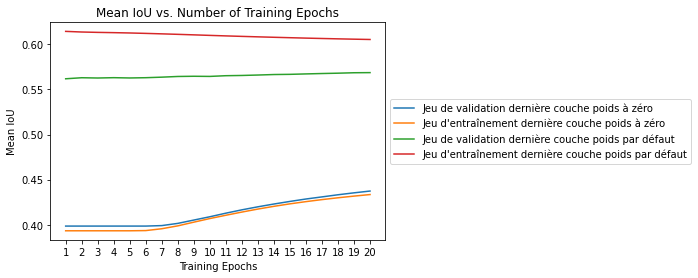

In [12]:
#inspiré de https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html#comparison-with-model-trained-from-scratch
def show_training_per_epoch(list_to_show, num_epochs):

  plt.figure(facecolor='white')
  plt.title("Mean IoU vs. Number of Training Epochs")
  plt.xlabel("Training Epochs")
  plt.ylabel("Mean IoU")

  min = 0.0
  max = 0.0
  for name, value in list_to_show.items():
    plt.plot(range(1,num_epochs+1),[h for h in value],label=name)
    min = np.min([h for h in value]) if (np.min([h for h in value])<min) or (min is 0.0) else min
    max = np.max([h for h in value]) if np.max([h for h in value])>max else max


  plt.ylim((min-0.01,max+0.01))
  plt.xticks(np.arange(1, num_epochs+1, 1.0))
  plt.legend(bbox_to_anchor=(1,0.5) , loc='center left')
  plt.show()

show_training_per_epoch({"Jeu de validation dernière couche poids à zéro":model_weight_init_at_zero_on_last_qualifier_layer_val_hist,
                         "Jeu d'entraînement dernière couche poids à zéro":model_weight_init_at_zero_on_last_qualifier_layer_train_hist,
                         "Jeu de validation dernière couche poids par défaut":model_last_qualifier_layer_loose_val_hist, 
                         "Jeu d'entraînement dernière couche poids par défaut":model_last_qualifier_layer_loose_train_hist},
                        num_epochs)

# Visualisation d'exemple par modèle

## Récupération d'images non soumises à des droits d'auteur



In [13]:
!rm -r /content/test_images

%cd /content
!git clone https://github.com/nyluje/RCP209DeeplabExperiment

!cp -r /content/RCP209DeeplabExperiment/test_images /content
!rm -r /content/RCP209DeeplabExperiment
!rm -r /content/test_images/readme.md

rm: cannot remove '/content/test_images': No such file or directory
/content
Cloning into 'RCP209DeeplabExperiment'...
remote: Enumerating objects: 93, done.
remote: Counting objects: 100% (93/93), done.
remote: Compressing objects: 100% (89/89), done.
remote: Total 93 (delta 45), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (93/93), done.


## Parmètres pour la représentation des classes


Les éléments suivant servent à nommer les classes et leur attribuer les couleurs utilisées par celles-ci par les masques de segmentation.

In [14]:
#inspiré de https://notebook.community/cshallue/models/research/deeplab/deeplab_demo et https://github.com/valeoai/ZS3/blob/master/zs3/dataloaders/utils.py

def get_pascal_labels():
    """Load the mapping that associates pascal classes with label colors
    Returns:
        np.ndarray with dimensions (21, 3)
    """
    return np.asarray(
        [
            [0, 0, 0],
            [128, 0, 0],
            [0, 128, 0],
            [128, 128, 0],
            [0, 0, 128],
            [128, 0, 128],
            [0, 128, 128],
            [128, 128, 128],
            [64, 0, 0],
            [192, 0, 0],
            [64, 128, 0],
            [192, 128, 0],
            [64, 0, 128],
            [192, 0, 128],
            [64, 128, 128],
            [192, 128, 128],
            [0, 64, 0],
            [128, 64, 0],
            [0, 192, 0],
            [128, 192, 0],
            [0, 64, 128],
        ]
    )

def label_to_color_image(label):
  """Adds color defined by the dataset colormap to the label.

  Args:
    label: A 2D array with integer type, storing the segmentation label.

  Returns:
    result: A 2D array with floating type. The element of the array
      is the color indexed by the corresponding element in the input label
      to the PASCAL color map.

  Raises:
    ValueError: If label is not of rank 2 or its value is larger than color
      map maximum entry.
  """
  if np.ndim(label) != 2:
    raise ValueError('Expect 2-D input label')

  colormap = get_pascal_labels()

  if np.max(label) >= len(colormap):
    raise ValueError('label value too large.')

  return colormap[label]

LABEL_NAMES = np.asarray([
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
])

FULL_LABEL_MAP = np.arange(len(LABEL_NAMES)).reshape(len(LABEL_NAMES), 1)
FULL_COLOR_MAP = label_to_color_image(FULL_LABEL_MAP)


## Fonction d'affichage

Comme pour la classe `IntersectionOverUnion`, la fonction d'affichage, applique une softmax sur la prédiction du modèle, la couche parmi les 21 qui a la valeur maximum pour un pixel détermine la classe attribué à chaque pixel.

In [15]:
#inspiré de https://notebook.community/cshallue/models/research/deeplab/deeplab_demo

def show_demo(models_dict={"Model par défaut":models.segmentation.deeplabv3_mobilenet_v3_large(pretrained=True,progress=False)},dataset_dir_root="/content",specific_dataset_dir='test_images',image_root_name='img',image_idx=2, device=device):

  path_to_images = Path(os.path.join(dataset_dir_root,specific_dataset_dir))
  number_of_images=len(os.listdir(path_to_images))

  for i in range(0,number_of_images):


    padding_index= "0"*(image_idx-len(str(number_of_images)))
    image_id=image_root_name+padding_index+str(i+1)
    image_path = Path(os.path.join(path_to_images,image_id+'.jpg'))

    img = read_image(str(image_path))
    img_pil = T.functional.to_pil_image(read_image(str(image_path)))

    batch_img = torch.stack([img])
    
    batch = T.functional.convert_image_dtype(batch_img, dtype=torch.float)
    batch = T.functional.normalize(batch,mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225))
    batch = batch.to(device)

    for idx,model_to_use in models_dict.items():

      model_to_use.to(device).eval()

      output = model_to_use(batch)['out']
      #print(f"output shape {output.shape}")
      normalized_masks = torch.nn.functional.softmax(output, dim=1)
      #print(f"normalized_masks shape {normalized_masks.shape}")
      mask = normalized_masks.argmax(1)
      segmentation_layout = T.functional.to_pil_image(mask[0].int())

      #del output
      #del model_to_use
      #torch.cuda.empty_cache()

      plt.figure(figsize=(15, 5), linewidth=10, edgecolor="#04253a", facecolor="white")
      grid_spec = gridspec.GridSpec(1, 4, width_ratios=[6, 6, 6, 1])

      plt.suptitle(f"model: {idx}, image: {image_id}", size=18, y=0.87)
      
      plt.subplot(grid_spec[0])
      plt.imshow(img_pil)
      plt.axis('off')
      plt.title('input image')

      plt.subplot(grid_spec[1])
      seg_image = label_to_color_image(segmentation_layout).astype(np.uint8)
      plt.imshow(seg_image)
      plt.axis('off')
      plt.title('segmentation map')

      plt.subplot(grid_spec[2])
      plt.imshow(img_pil)
      plt.imshow(seg_image, alpha=0.7)
      plt.axis('off')
      plt.title('segmentation overlay')

      unique_labels = np.unique(segmentation_layout)
      unique_labels = np.delete(unique_labels, np.where(unique_labels == 255))
      ax = plt.subplot(grid_spec[3])
      plt.imshow(
          FULL_COLOR_MAP[unique_labels].astype(np.uint8), interpolation='nearest')
      ax.yaxis.tick_right()
      plt.yticks(range(len(unique_labels)), LABEL_NAMES[unique_labels])
      plt.xticks([], [])
      ax.tick_params(width=0.0)
      plt.grid('off')

      plt.show()


    #del batch
    #torch.cuda.empty_cache()



## Rendu de la démonstration

A partir de trois images de test, le rendu de la segmentation est effectué avec les deux modèles entrainés et le modèle par défaut `deeplabv3_mobilenet_v3_large`, utilisé comme base pour les deux modèles entraînés:
* Le modèle avec les poids initialisés à 0.01 arrive à détecter quelques caratéristiques de segmentation.
* Le modèle sans les poids initialisés offre un résultat proche du modèle par défaut (sur les trois exemples utilisés).



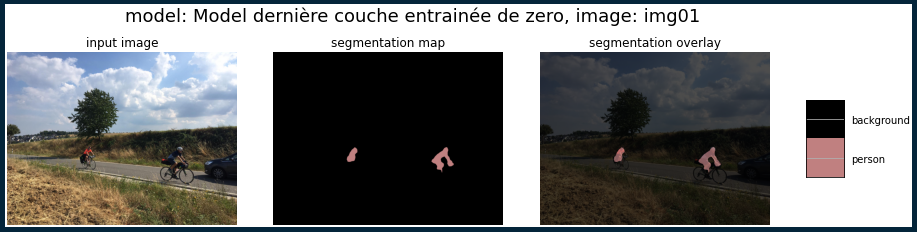

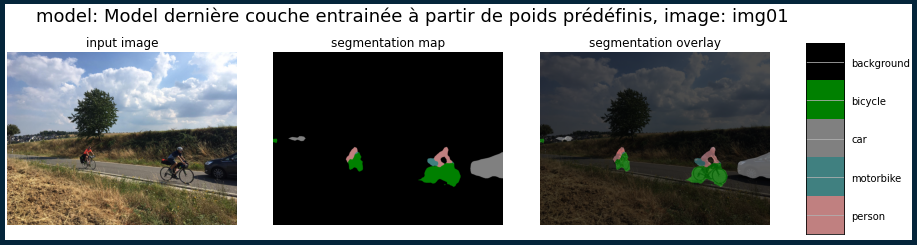

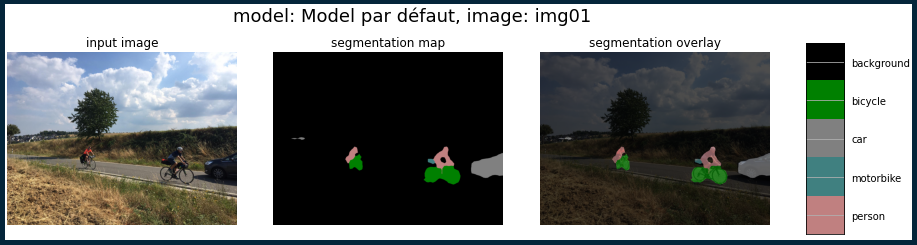

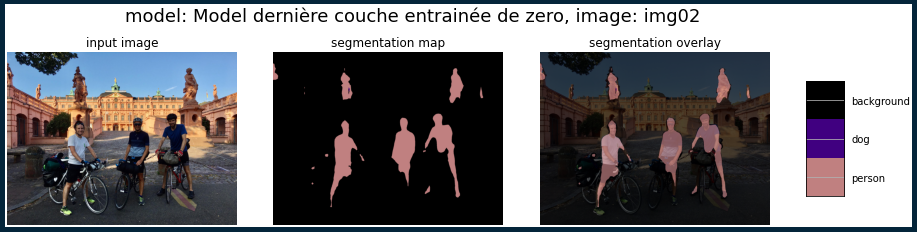

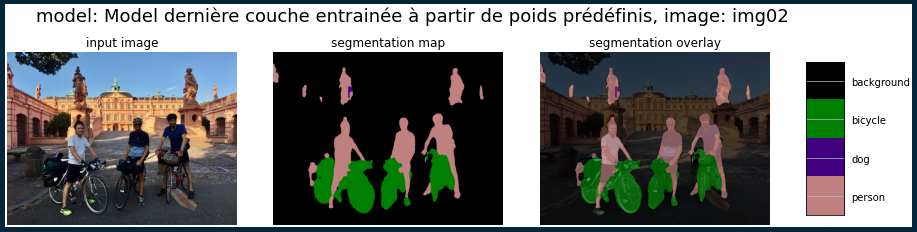

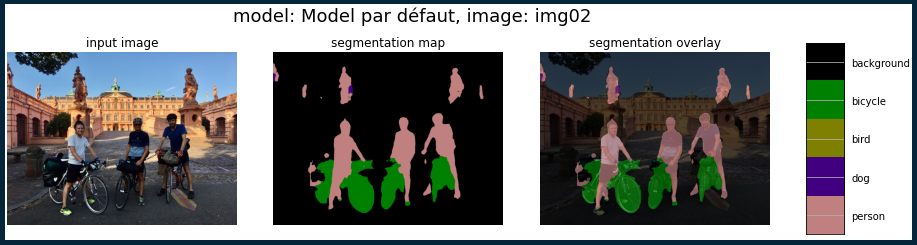

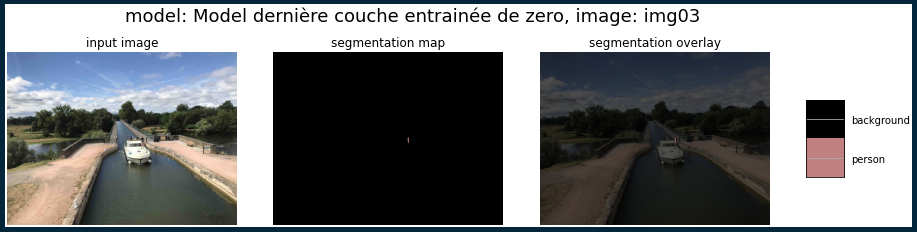

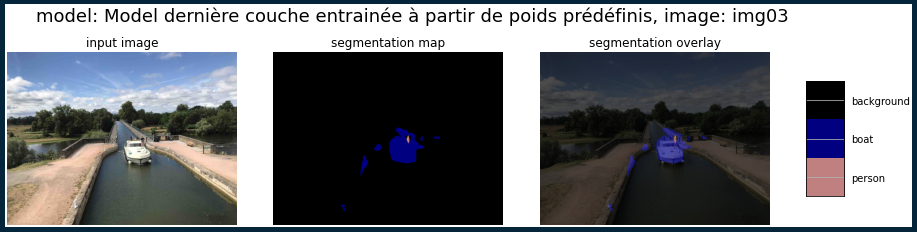

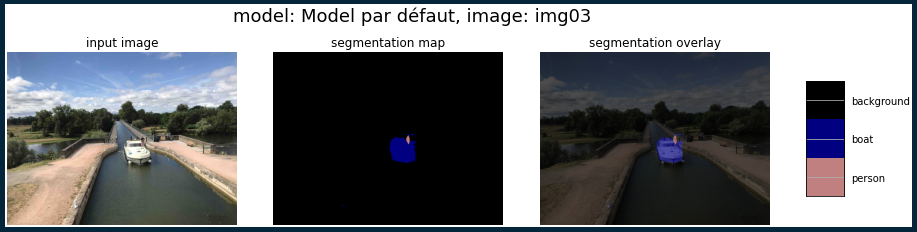

In [16]:
show_demo({"Model dernière couche entrainée de zero": model_weight_init_at_zero_on_last_qualifier_layer, 
           "Model dernière couche entrainée à partir de poids prédéfinis": model_last_qualifier_layer_loose,
           "Model par défaut":models.segmentation.deeplabv3_mobilenet_v3_large(pretrained=True,progress=False)})
